In [32]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib

In [27]:
# filtering and variable generation
def prepare_data(filename):
    data = pd.read_csv(filename)
    
    print(data['key_id'].count())
    
    # filter
    data = data[(data['stroke_in_order'] == 0) & 
     (data['drawing_time_min'] >= 0) & 
     (data['drawing_time_draw'] > 100)]
    
    print(data['key_id'].count())
    
    data = data[(data['recognized'] == True)]
    print(data['key_id'].count())    
    
    # generate seconds data
    data['dt_sec'] = data['drawing_time_draw'] / 1000.0
    data['dt_sec_floor'] = np.floor(data['dt_sec'])
    
    
    return data
    

In [113]:
def bin_data(data):
    groups = data.groupby('dt_sec_floor')
    counts = groups['dt_sec_floor'].count()
    sizes = counts.to_frame()
    sizes = sizes.rename(columns = {'dt_sec_floor':'count'})
    sizes = sizes.reset_index()
    sizes = sizes.rename(columns = {'dt_sec_floor':'x0'})
    alltotal = data['key_id'].count()

    sizes['x1'] = sizes['x0'] + 1
    sizes['freq'] = sizes['count'] / alltotal
    #sizes = sizes.round({'freq': 3})

    #sizes.describe()

    return sizes

In [120]:
def to_hist(data):
    hist = data.T.to_dict().values()
    return hist

In [121]:
def get_drawings(key_id, data, count, max_bin):
    #filename = "/Users/vlandham/code/data/quickdraw/raw/" + draw_id + ".ndjson"
    

SyntaxError: unexpected EOF while parsing (<ipython-input-121-964579133449>, line 3)

In [118]:
keys = ['dog', 'cat']

output = {keys: keys}

for key_id in keys:
    
    
    filename = "data/" + key_id +".stats.csv"
    data = prepare_data(filename)
    bins = bin_data(data)
    hist = to_hist(bins)
    
    output[key_id] = {}
    output[key_id]['hist'] = hist
    output[key_id]['drawings'] = get_drawings(key_id, data, 20, 25)


152159
151962
143102


In [131]:

groups = data.groupby('dt_sec_floor')
drawing_ids = groups['key_id'].apply(lambda x:  x.sample(n = 20) if len(x) > 20 else x.sample(n = 1))
#for name in drawing_ids.index:
#    print(name)

(0.0, 55998)
(0.0, 151914)
(0.0, 84229)
(0.0, 114136)
(0.0, 131554)
(0.0, 141633)
(0.0, 50188)
(0.0, 102656)
(0.0, 44661)
(0.0, 18284)
(0.0, 42612)
(0.0, 64144)
(0.0, 41015)
(0.0, 41166)
(0.0, 144484)
(0.0, 46611)
(0.0, 143945)
(0.0, 2850)
(0.0, 113394)
(0.0, 130301)
(1.0, 16427)
(1.0, 48895)
(1.0, 69928)
(1.0, 58323)
(1.0, 31234)
(1.0, 60524)
(1.0, 117915)
(1.0, 77652)
(1.0, 14165)
(1.0, 116822)
(1.0, 88753)
(1.0, 90295)
(1.0, 63001)
(1.0, 39236)
(1.0, 1256)
(1.0, 52661)
(1.0, 122282)
(1.0, 148161)
(1.0, 79751)
(1.0, 31978)
(2.0, 122584)
(2.0, 80084)
(2.0, 142035)
(2.0, 53703)
(2.0, 12365)
(2.0, 103256)
(2.0, 4563)
(2.0, 27253)
(2.0, 92193)
(2.0, 14391)
(2.0, 44277)
(2.0, 51613)
(2.0, 71044)
(2.0, 52189)
(2.0, 83996)
(2.0, 52061)
(2.0, 108842)
(2.0, 11143)
(2.0, 127764)
(2.0, 35631)
(3.0, 31617)
(3.0, 110097)
(3.0, 10235)
(3.0, 53310)
(3.0, 71563)
(3.0, 69936)
(3.0, 67722)
(3.0, 3847)
(3.0, 20075)
(3.0, 1897)
(3.0, 58193)
(3.0, 77682)
(3.0, 101800)
(3.0, 91718)
(3.0, 61561)
(3.0, 9719

In [117]:

hist = bins.T.to_dict().values()
for val in hist:
    print(val['x0'])
#sizes.reset_index()
#sizes.columns()
#sizes = pd.DataFrame(data =counts)

#counts.columns('x0', 'count')
#sizes.columns('x0')
#bins['freq'] = bins['key_id'] / data['key_id'].count()

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
26.0
27.0
29.0
30.0
44.0
69.0


In [119]:
output = {'keys': []}

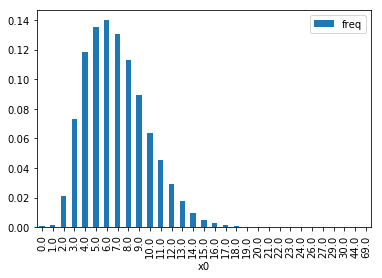

In [97]:
sizes.plot.bar(x = 'x0', y = 'freq')